<a href="https://colab.research.google.com/github/abhiiyer/ERA1/blob/main/Session-6/S6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
         Dropout2d-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,152
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
         Dropout2d-8           [-1, 16, 28, 28]               0
         MaxPool2d-9           [-1, 16, 14, 14]               0
           Conv2d-10           [-1, 16, 14, 14]           2,304
             ReLU-11           [-1, 16, 14, 14]               0
      BatchNorm2d-12           [-1, 16, 14, 14]              32
        Dropout2d-13           [-1, 16, 14, 14]               0
           Conv2d-14           [-1, 16,

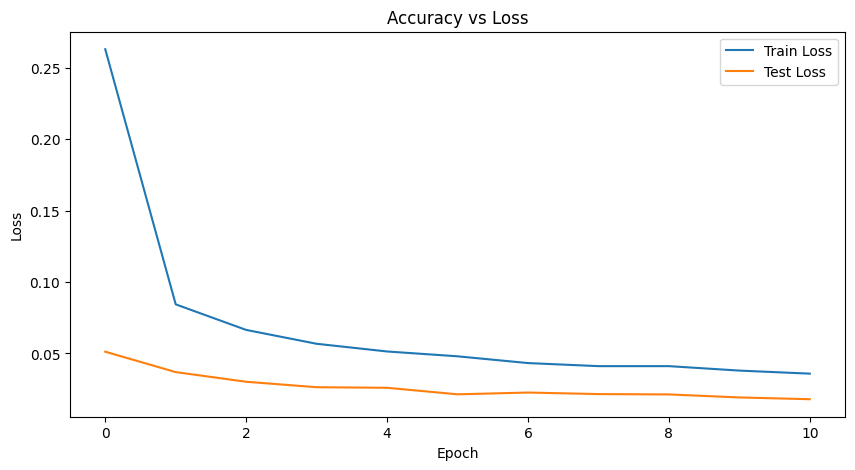

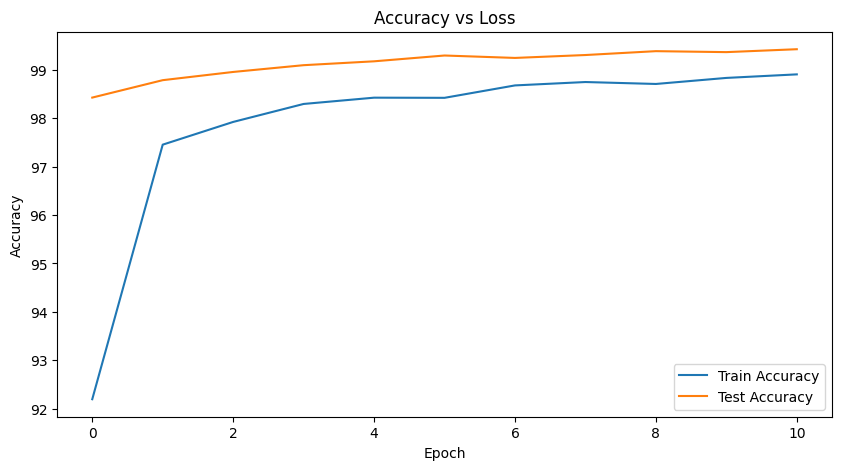

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
         Dropout2d-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,152
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
         Dropout2d-8           [-1, 16, 28, 28]               0
         MaxPool2d-9           [-1, 16, 14, 14]               0
           Conv2d-10           [-1, 16, 14, 14]           2,304
             ReLU-11           [-1, 16, 14, 14]               0
      BatchNorm2d-12           [-1, 16, 14, 14]              32
        Dropout2d-13           [-1, 16, 14, 14]               0
           Conv2d-14           [-1, 16,

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchsummary import summary

# Define the network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1, bias=False),  # input: 28x28x1, output: 28x28x8, RF: 3x3
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout2d(0.1)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1, bias=False),  # input: 28x28x8, output: 28x28x16, RF: 5x5
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1)
        )
        self.pool1 = nn.MaxPool2d(2, 2)  # input: 28x28x16, output: 14x14x16, RF: 10x10
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1, bias=False),  # input: 14x14x16, output: 14x14x16, RF: 12x12
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1, bias=False),  # input: 14x14x16, output: 14x14x16, RF: 14x14
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1)
        )
        self.pool2 = nn.MaxPool2d(2, 2)  # input: 14x14x16, output: 7x7x16, RF: 28x28
        self.conv5 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=0, bias=False),  # input: 7x7x16, output: 5x5x16, RF: 30x30
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(16, 10, 3, padding=0, bias=False),  # input: 5x5x16, output: 3x3x10, RF: 32x32
        )
        self.gap = nn.AdaptiveAvgPool2d(1)  # input: 3x3x10, output: 1x1x10

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the MNIST dataset and apply transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model
model = Net().to(device)

# Print the model summary
summary(model, (1, 28, 28))

# Define the optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Training loop
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
epochs = 20
best_accuracy = 0.0

for epoch in range(epochs):
    model.train()
    correct = 0
    running_loss = 0.0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_acc = (correct / total) * 100
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)

    model.eval()
    correct = 0
    running_loss = 0.0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

    test_loss = running_loss / len(test_loader)
    test_acc = (correct / total) * 100
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)

    print(f'Epoch {epoch + 1}/{epochs}: '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

    if test_acc > best_accuracy:
        best_accuracy = test_acc
        best_model_weights = model.state_dict()

    if test_acc >= 99.41:
        print('Validation accuracy reached 99.41%, stopping training...')
        break

# Load the best model weights
model.load_state_dict(best_model_weights)

# Plot accuracy vs loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Accuracy vs Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Loss')
plt.legend()
plt.show()

# Print model summary
summary(model, (1, 28, 28))
